# __Payments Fraud Detection:__
# __An Anomaly Detection problem__

------------------------------------------------------------------------------------------------

One of the problems in consumer finance is card fraud, money that is charged to customers for products that they have not purchased. This is a major problem for the financial sector since, in addition to monetary losses, customer loyalty decreases. Remember that the current monetary system is based on trust, and money is the first thing that escapes when there is no trust in entities.

The data for this issue comes from the following Kaggle address:

**Url:** https://www.kaggle.com/mlg-ulb/creditcardfraud


### __About the dataset:__

It has a total of **30 predictor variables X** and a **continuous variable to predict Y**.

The total number of samples is 284,807 transactions.

* Thee dataset contains card transactions carried out in September 2013 by European entities. 
* These transactions occurred in two days, producing a total of 492 fraudulent transactions out of a total of 284,807.
* The dataset is highly unbalanced, the positive class (fraud) is only 0.172% of the total transactions.

**Variable information:**

* __Dependent variable Y:__ The 'Class' variable is the response, it indicates whether that transaction is fraudulent (1) or not fraudulent (0).

* __Independent variables X:__ All variables in this dataset are numeric. Two of them are 'Time' and 'Amount', both of which are original variables. The rest are the result of a PCA transformation, with V1-V28 being the main components. For reasons of confidentiality, the original variables and more information about the data are not provided.

  * 'Time': seconds between each transaction and the first transaction in the dataset
  * 'Amount': monetary units of the transaction
  * Variables 'V1-V28': principal components of a variable transformation using PCA

### __Problem Statement__

* __Context:__

In a real-world scenario, unsupervised algorithms are used in these cases to filter out the total number of transactions which are anomalous. Sometimes business rules are used to do this filtering, but many times those rules are very difficult to formulate. Since it is not feasible to analyze all transactions, an __unsupervised model__ that filters out strange behavior is very useful for a first screening. 

For this, characteristics of each transaction (X) are found and with anomaly detectors it is estimated which are abnormal and which are not.

Subsequently, all those anomalous transactions are audited and the real labels (Y) are obtained. It finds which transactions are fraudulent (Y=1) and which are not (Y=0). At some point, the financial institution would have reached sufficient labeled data (X,Y) that it can use to perform a supervised learning classifier.

* __Approach of this project:__

In this case we have the characteristics of each transaction (X) and the label indicating whether they are fraud or not (Y). We could directly perform a supervised learning classifier, but the goal for this business case is to have an approximation of how useful an __anomaly detection model__ can be in previous steps.

1. I'm going to assume first that there is no label (Y) and make an anomaly detection model with only the features (X). 

2. I will find which transactions I get as abnormal and then compare to the actual labels (Y). In this way we can see how an anomaly detector could serve in that first filtering.

# Importing libraries:

In [40]:
# Data preprocessing
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import scikitplot as skplt
new_style = {'grid': False}
plt.rc('axes', **new_style)

# Machine Learning model and metrics
from sklearn.neighbors import LocalOutlierFactor
import sklearn.metrics as metrics
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA

# Other settings
import warnings
warnings.filterwarnings("ignore")

# Defining functions:

In [47]:
def NormalizeData(data):
    '''Function that normilize the data'''
    return (data - np.min(data)) / (np.max(data) - np.min(data))

def graph_matrix_confusion(matrix):
    '''
    Function that design the matrix graph
    '''
    df_matrix_confusion = pd.DataFrame(matrix,
                     ['True Normal','True Fraud'],
                     ['Pred Normal','Pred Fraud'])
    plt.figure(figsize = (8,4))
    sns.set(font_scale=1.4)
    plt.title(u'Confusion matrix')
    _ = sns.heatmap(df_matrix_confusion, annot=True, annot_kws={"size": 16}, fmt='g')
    
def reporting_model(y_true, y_pred):
    '''
    Function that adds the metrics infos of the model
    '''
    matrix_confusion = metrics.confusion_matrix(y_true, y_pred)
    roc_auc = metrics.roc_auc_score(y_true, y_pred)
    metric_f1 = metrics.f1_score(y_true, y_pred)
    print(u'ROC-AUC: {}'.format(round(roc_auc,2)))
    print(u'F1-score: {}'.format(round(metric_f1,2)))
    print("\nAccuracy\t{}".format(round(metrics.accuracy_score(y_true, y_pred),3)))  
    print("Sensitivity/Recall\t{}".format(round(metrics.recall_score(y_true, y_pred),3)))
    print(u"Precision\t{}".format(round(metrics.precision_score(y_true, y_pred),3)))   
    graph_matrix_confusion(matrix_confusion)
    
def double_hist(y_prob_pos, y_prob_neg):
    
    '''
    Function that represent in a graph the probabilities
    assigned to the fraud and non fraud class
    '''
    fig = plt.figure(figsize=(20,10))
    ax = sns.distplot(y_prob_pos,norm_hist=True, bins=30, hist=False,
    label='', kde_kws={"color": "r", "lw": 5})  
    ax2 = ax.twinx()
    sns.distplot(y_prob_neg,norm_hist=True ,ax=ax2, bins=30, hist=False,
    label='', kde_kws={"color": "g", "lw": 5}) 
    sns.set_style("whitegrid", {'axes.grid' : False})
    ax.figure.legend(['Fraud Class', 'Non Fraud Class'])
    new_style = {'grid': False}
    plt.rc('axes', **new_style)
    plt.title('Representation of the probabilities assigned to both classes')
    plt.show()

# Reading the data:

In [10]:
XY = pd.read_csv('/content/creditcard.csv')

In [11]:
print(u'- Rows in the dataset: {}'.format(XY.shape[0]))
print(u'- Columns in the dataset: {}'.format(XY.shape[1]))
print(u'- Variable names: {}'.format(list(XY.columns)))
XY[:2]

- Rows in the dataset: 284807
- Columns in the dataset: 31
- Variable names: ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Class']


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0


In [12]:
XY.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

As we can see, all the variables in the dataset are numerical and there are no missing values

In [13]:
# Let's see the Class distribution
XY.Class.value_counts()

0    284315
1       492
Name: Class, dtype: int64

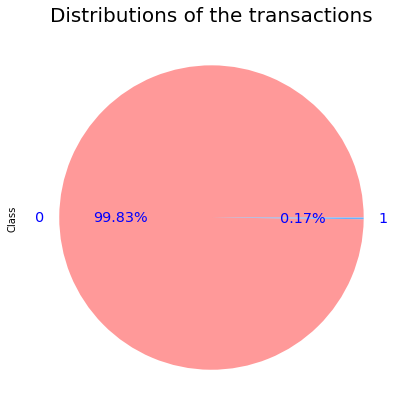

In [6]:
# Adding colors
colors = ['#ff9999','#66b3ff']

# Plotting pie chart
XY['Class'].value_counts().plot(kind='pie', figsize=(7,7), colors=colors, autopct='%.2f%%', textprops={'size': 'x-large','color':"b"})
_ = plt.title('Distributions of the transactions', fontsize=20)

As mentioned before, the classes are very unbalanced since there are hardly any fraudulent cases.

# Division features X + target Y

In [15]:
X = XY.drop('Class', axis=1)
Y = XY['Class']

# PCA Representation of the classes

To balance the data for this representation we will use 2,000 samples for the Non Fraud Class and 20 samples for the Fraud Class (10% of X)

In [23]:
# Separating positive and negative samples of the variable Class
df_plt = XY[XY['Class']==0].sample(2000)
df_plt_pos = XY[XY['Class']==1].sample(20)

# Concatenating both variables in one dataframe
df_plt = pd.concat([df_plt,df_plt_pos])

# Separating the dependent and independent variables
y_plt = df_plt['Class']
X_plt = df_plt.drop('Class',axis=1)

In [24]:
pca3 = PCA(n_components=3)
X_PCA = pca3.fit_transform(X_plt)

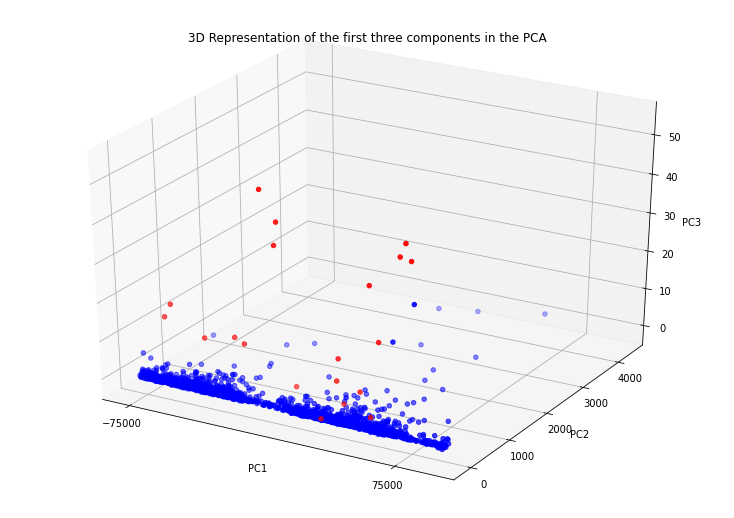

In [11]:
# Plotting the PCA visual representation of 3 components
fig = plt.figure(figsize=(10,7))
ax = Axes3D(fig)
ax.scatter(X_PCA[:,0], X_PCA[:,1], X_PCA[:,2], c=y_plt, cmap=plt.cm.get_cmap("bwr"))
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_xticks([-75000,75000])
ax.set_title('3D Representation of the first three components in the PCA')
plt.show()

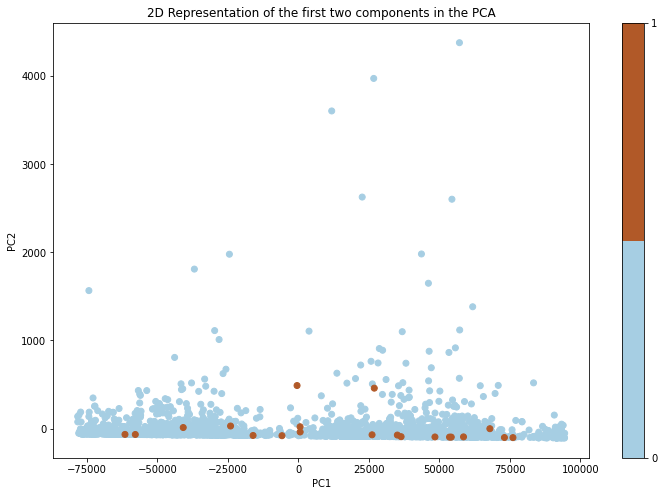

In [12]:
# Plotting the PCA visual representation of 2 components
plt.figure(figsize=(12,8))
plt.scatter(X_PCA[:,0], X_PCA[:,1], c=y_plt, cmap=plt.cm.get_cmap("Paired", 2))
plt.colorbar(ticks=range(2))
plt.title('2D Representation of the first two components in the PCA')
plt.xlabel('PC1'); _=plt.ylabel('PC2')

# Anomaly Detection Model

* I will use the __Local Outlier Factor method__ -> According to sklearn website: "The Local Outlier Factor (LOF) algorithm is an unsupervised anomaly detection method which computes the local density deviation of a given data point with respect to its neighbors. It considers as outliers the samples that have a substantially lower density than their neighbors"

* We are going to fit the model to all X data.

* A parameter that can be changed is the **number of neighbors**. Sklearn website offers some rules to set it. A number of 20 neighbors appears to work well in general. Overall, the smaller the number, the more the model fits.


In [27]:
clf=LocalOutlierFactor(n_neighbors=10, 
                        algorithm='auto', 
                        leaf_size=30,
                        metric='minkowski', 
                        p=2, 
                        metric_params=None, 
                        n_jobs=-1,
                        novelty=False)

__Note by the parameters choosen:__
1. __*n_neighbors:*__ If n_neighbors is larger than the number of samples provided, all samples will be used.
2. __*algorithm:*__ when is equal to "auto" will attempt to decide the most appropriate algorithm based on the values passed to fit method.
3. __*p:*__ This is the parameter used for calculating the distance, p=2 is euclidean distance
4. __*n_jobs:*__ Number of jobs to run in parallel. None means 1 and -1 means using all processors.
5. __*novelty:*__ we set it to False because it is only meant to be used for outlier detection 

In [28]:
#%%time
clf.fit(X)

LocalOutlierFactor(n_jobs=-1, n_neighbors=10)

* The LOF model gives us as a result what are called __*negative anomaly factors*__. The higher this value, the more normal the point is.

* We set the threshold at 2% to have margin. That is, if we want to keep the 2% of most anomalous points, we must keep the 2% lowest values.

In [31]:
# Creating variable with negative factors
lof_factors = clf.negative_outlier_factor_
lof_factors

# Setting the threshold to 2%
Y_pred_class = lof_factors.copy()
Y_pred_class[lof_factors >= np.percentile(lof_factors,2.)] = 0
Y_pred_class[lof_factors < np.percentile(lof_factors,2.)] = 1

ROC-AUC: 0.67
F1-score: 0.06

Accuracy	0.98
Sensitivity/Recall	0.358
Precision	0.031


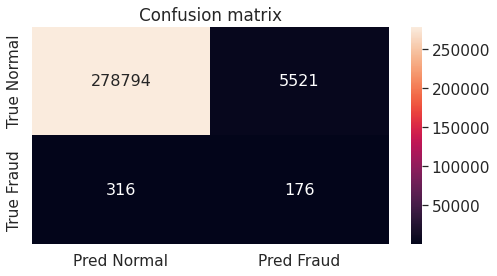

In [32]:
reporting_model(Y, Y_pred_class)

As we can see, with two percent of the sample detected as fraud, we detect almost a 40% of fraudulent transactions.

## Representation of probabilities:

Normalizing the factors to the range (0,1) to get an estimate of probabilities:

In [33]:
Y_prob = NormalizeData(lof_factors)
Y_pred_prob_pos = NormalizeData(lof_factors)[np.where(Y == 1)]
Y_pred_prob_neg = NormalizeData(lof_factors)[np.where(Y == 0)]

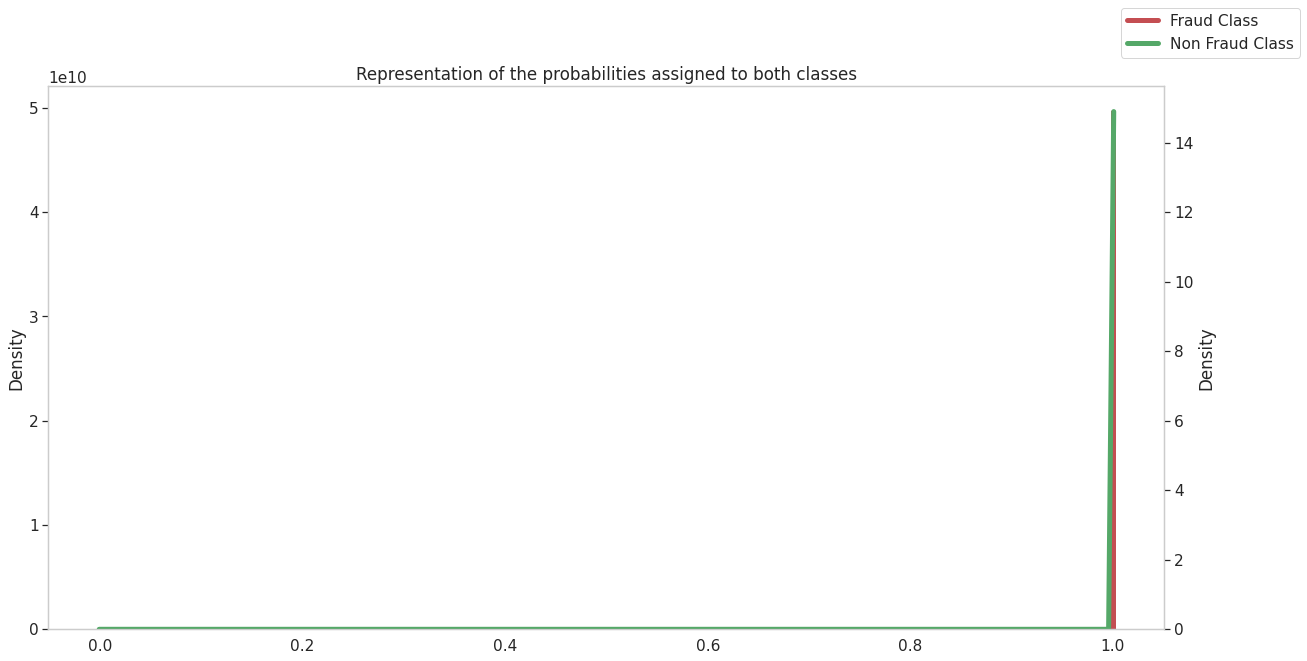

In [48]:
double_hist(Y_pred_prob_pos, Y_pred_prob_neg)

The model assigns values centered on 1 (anomalous) to the fraudulent class. On the other hand, the non-fraudulent class has many values of 0s and 1s.

## Representation of the gain of having a model:

At this point we analyze what improvement the model gives us. In other words, what advantage does a company have using an anomaly detection model over not using it.

I will create an array with an estimation of probabilities of 1s and 0s (We have already the 1s and we create the 0s like $P_0 = 1-P_1$

In [35]:
Y_probs_1_0 = np.column_stack((Y_prob,list(map(lambda x: 1-x, Y_prob))))
Y_probs_1_0

array([[1.00000000e+00, 5.51059198e-12],
       [1.00000000e+00, 4.68358685e-12],
       [1.00000000e+00, 1.34428024e-11],
       ...,
       [1.00000000e+00, 7.99127431e-12],
       [1.00000000e+00, 6.34747810e-12],
       [1.00000000e+00, 1.59897651e-11]])

We can represent the accumulated profit that we obtain between having a model and not having it:

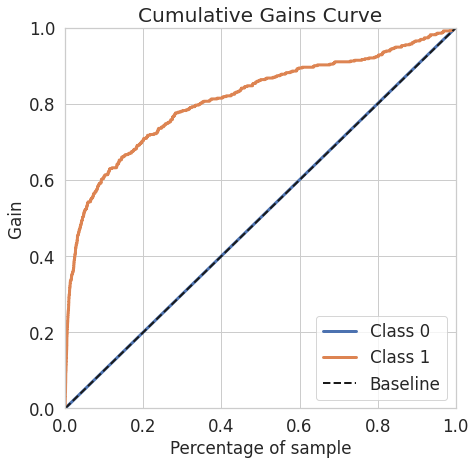

In [36]:
skplt.metrics.plot_cumulative_gain(Y, Y_probs_1_0, figsize=(7,7))
plt.show()

And the Lift curve, which is widely used in classification models, since it tells us, for each percentage of transactions that are most likely to be fraud, what is the profit that we obtain with the model. In this case, if we take the 10% most likely trades, we improve to a random decision by about 1000%

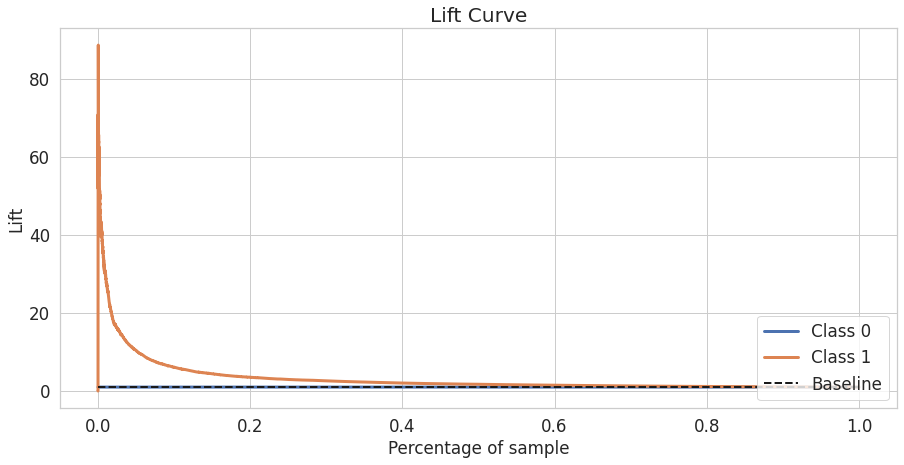

In [38]:
skplt.metrics.plot_lift_curve(Y, Y_probs_1_0, figsize=(15,7))
#plt.axvline(x=0.1, color='red', linestyle='--')
plt.show()

At this point, by simply auditing a small percentage of all total transactions, the company would find a big number of the fraudulent transactions. This would save time and effort for many workers, which could be devoted to other tasks.

More details about the Lift Curve Chart here: http://www2.cs.uregina.ca/~dbd/cs831/notes/lift_chart/lift_chart.html